In [1]:
from datetime import datetime
import warnings
import os
from collections import Counter

import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error as mape
import numpy as np
import pymc as pm
import arviz as az
from sklearn.preprocessing import MinMaxScaler

from get_model_training_data_05 import get_features_and_data
from get_model_training_data_05 import weighted_absolute_percentage_error as wape

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (25, 15)})
sns.set(font_scale=2)
sns.set_style("ticks")

warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

In [2]:
%load_ext autoreload
%autoreload 2

## Load Training and Testing Data

In [3]:
(df, train_df, test_df, feature_names, next_two_weeks) = get_features_and_data()

training examples = 2500, testing examples = 327


In [4]:
scaler = MinMaxScaler().fit(train_df[["days_since_previous_release"]])
train_df["days_since_previous_release"] = scaler.transform(train_df[["days_since_previous_release"]])
test_df["days_since_previous_release"] = scaler.transform(test_df[["days_since_previous_release"]])

In [5]:
scaler = MinMaxScaler().fit(df[["days_since_previous_release"]])
df["days_since_previous_release"] = scaler.transform(df[["days_since_previous_release"]])
next_two_weeks["days_since_previous_release"] = scaler.transform(next_two_weeks[["days_since_previous_release"]])

## Model-Building and Evaluation

In [6]:
with pm.Model() as model:
    # data
    features = pm.MutableData("features", train_df[feature_names].T)
    # priors
    weights = pm.Normal("weights", mu=0, sigma=1, shape=len(feature_names))
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    error = pm.HalfNormal("error", sigma=0.5)
    # linear model
    mu = beta0 + pm.math.dot(weights, features)
    # likelihood
    pm.TruncatedNormal("y_pred", mu=mu, sigma=error, observed=train_df["prob_of_release"],
                       lower=0, upper=1, shape=features.shape[1])

In [7]:
with model:
    idata = pm.sample(1000, tune=1000, chains=4, random_seed=1024)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, beta0, error]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


In [8]:
weights_df = az.summary(idata, round_to=2, var_names="weights")
weights_df["feature"] = feature_names
weights_df = weights_df.reset_index().drop(columns=["index"]).set_index("feature").sort_values(by=["mean"], ascending=False)
weights_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
feature,,,,,,,,,
days_since_previous_release,1.02,0.03,0.96,1.07,0.0,0.0,2566.59,2655.27,1.0
WD_Tuesday,0.09,0.01,0.06,0.11,0.0,0.0,1505.21,2410.96,1.0
WD_Wednesday,0.08,0.01,0.06,0.11,0.0,0.0,1650.19,2273.55,1.0
WD_Monday,0.07,0.01,0.04,0.10,0.0,0.0,1727.08,2269.57,1.0
WD_Thursday,0.05,0.01,0.02,0.07,0.0,0.0,1887.06,2559.65,1.0
WD_Sunday,0.02,0.01,-0.01,0.04,0.0,0.0,1616.29,2085.89,1.0
month_holidays,0.00,0.00,-0.00,0.01,0.0,0.0,3154.86,3039.88,1.0
WD_Saturday,0.00,0.01,-0.02,0.03,0.0,0.0,1670.83,2464.21,1.0
previous_release,-0.21,0.01,-0.24,-0.18,0.0,0.0,3212.53,2727.33,1.0


In [9]:
az.summary(idata, round_to=2, var_names=["beta0", "error"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,0.28,0.01,0.25,0.30,0.0,0.0,1251.96,1734.87,1.0
error,0.17,0.00,0.16,0.17,0.0,0.0,3351.87,3286.03,1.0


### Out-of-Sample Evaluation

In [10]:
with model:
    pm.set_data({"features" : test_df[feature_names].T})
    pred_test = pm.sample_posterior_predictive(idata, predictions=True, var_names=["y_pred"])

Sampling: [y_pred]


Output()

In [11]:
y_pred = np.mean(pred_test.predictions["y_pred"].stack(all_draws=["chain", "draw"]).values, axis=1)

In [12]:
mape(test_df["prob_of_release"], y_pred)

0.24897352404505155

In [13]:
wape(test_df["prob_of_release"], y_pred)

0.23209634883031646

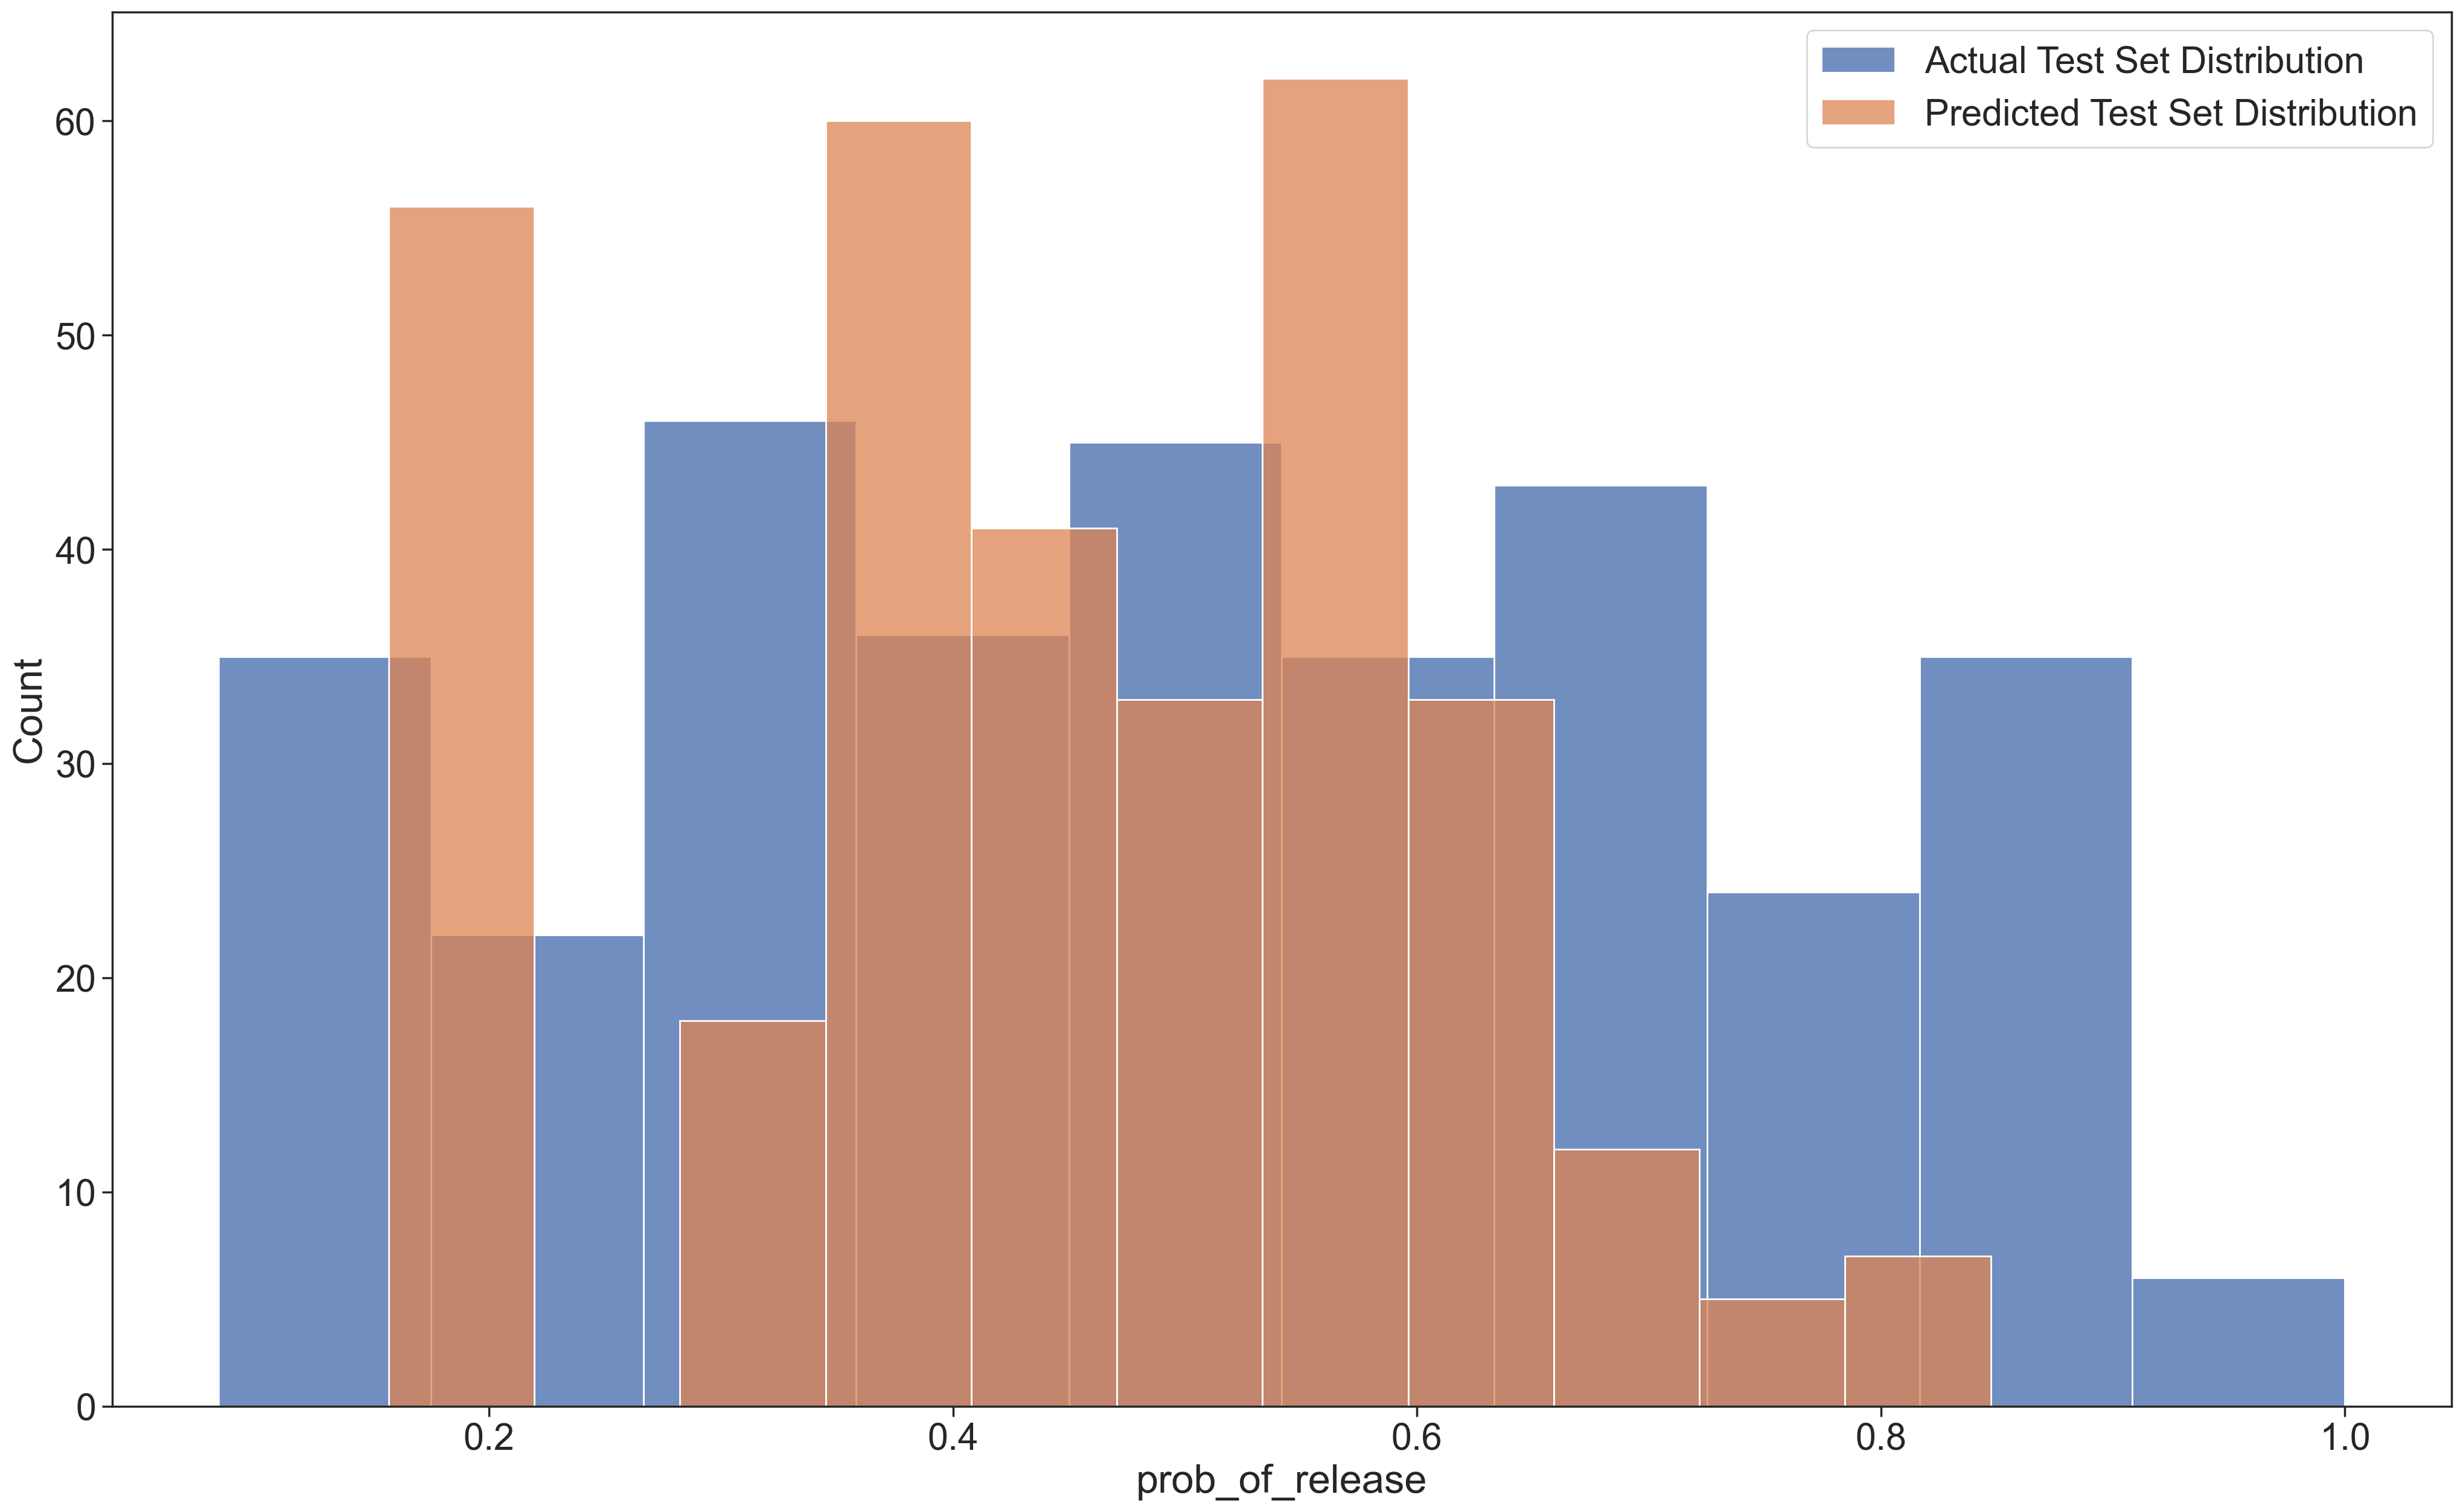

In [14]:
ax = sns.histplot(x=test_df["prob_of_release"], alpha=0.8, label="Actual Test Set Distribution")
sns.histplot(x=y_pred, ax=ax, label="Predicted Test Set Distribution")
ax.legend()
plt.show()

## Predictions for the Next Two Weeks

In [15]:
with pm.Model() as model:
    # data
    features = pm.MutableData("features", df[feature_names].T)
    # priors
    weights = pm.Normal("weights", mu=0, sigma=1, shape=len(feature_names))
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    error = pm.HalfNormal("error", sigma=0.5)
    # linear model
    mu = beta0 + pm.math.dot(weights, features)
    # likelihood
    pm.TruncatedNormal("y_pred", mu=mu, sigma=error, observed=df["prob_of_release"], lower=0, upper=1, shape=features.shape[1])

In [16]:
with model:
    idata = pm.sample(1000, tune=1000, chains=4, random_seed=1024)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, beta0, error]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


In [17]:
weights_df = az.summary(idata, round_to=2, var_names="weights")
weights_df["feature"] = feature_names
weights_df = weights_df.reset_index().drop(columns=["index"]).set_index("feature").sort_values(by=["mean"], ascending=False)
weights_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
feature,,,,,,,,,
days_since_previous_release,1.01,0.03,0.95,1.06,0.0,0.0,2716.12,2120.49,1.0
WD_Tuesday,0.10,0.01,0.08,0.13,0.0,0.0,1998.52,2652.65,1.0
WD_Wednesday,0.09,0.01,0.07,0.12,0.0,0.0,2183.72,2851.13,1.0
WD_Monday,0.08,0.01,0.06,0.11,0.0,0.0,1990.24,2442.70,1.0
WD_Thursday,0.06,0.01,0.04,0.09,0.0,0.0,1978.38,2730.01,1.0
WD_Sunday,0.03,0.01,0.00,0.05,0.0,0.0,2078.32,2713.91,1.0
WD_Saturday,0.01,0.01,-0.02,0.03,0.0,0.0,2073.92,2700.14,1.0
month_holidays,0.00,0.00,-0.01,0.01,0.0,0.0,3408.10,2807.67,1.0
previous_release,-0.21,0.01,-0.23,-0.18,0.0,0.0,2572.84,2671.05,1.0


In [18]:
az.summary(idata, round_to=2, var_names=["beta0", "error"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,0.28,0.01,0.25,0.30,0.0,0.0,1628.61,2018.01,1.0
error,0.17,0.00,0.16,0.17,0.0,0.0,3198.48,2566.83,1.0


In [19]:
with model:
    pm.set_data({"features" : next_two_weeks[feature_names].T})
    pred_next = pm.sample_posterior_predictive(idata, predictions=True, var_names=["y_pred"])

Sampling: [y_pred]


Output()

In [20]:
next_two_weeks["predicted_prob"] = np.mean(pred_next.predictions["y_pred"].stack(all_draws=["chain", "draw"]).values, axis=1)

In [21]:
hdi = pm.hdi(pred_next.predictions["y_pred"], hdi_prob=0.95)
next_two_weeks["predicted_min"] = hdi["y_pred"][:, 0]
next_two_weeks["predicted_max"] = hdi["y_pred"][:, 1]

In [22]:
next_two_weeks[["index", "predicted_min", "predicted_prob", "predicted_max"]].round(4)

,index,predicted_min,predicted_prob,predicted_max
0,2024-11-22,0.0000,0.1396,0.3466
1,2024-11-23,0.0000,0.1631,0.3743
2,2024-11-24,0.0480,0.3633,0.6670
3,2024-11-25,0.1545,0.4652,0.8030
4,2024-11-26,0.2159,0.5430,0.8565
5,2024-11-27,0.2678,0.5823,0.9036
6,2024-11-28,0.2783,0.5950,0.9077
7,2024-11-29,0.2610,0.5905,0.8993
8,2024-11-30,0.3532,0.6488,0.9565
9,2024-12-01,0.4533,0.7133,0.9977


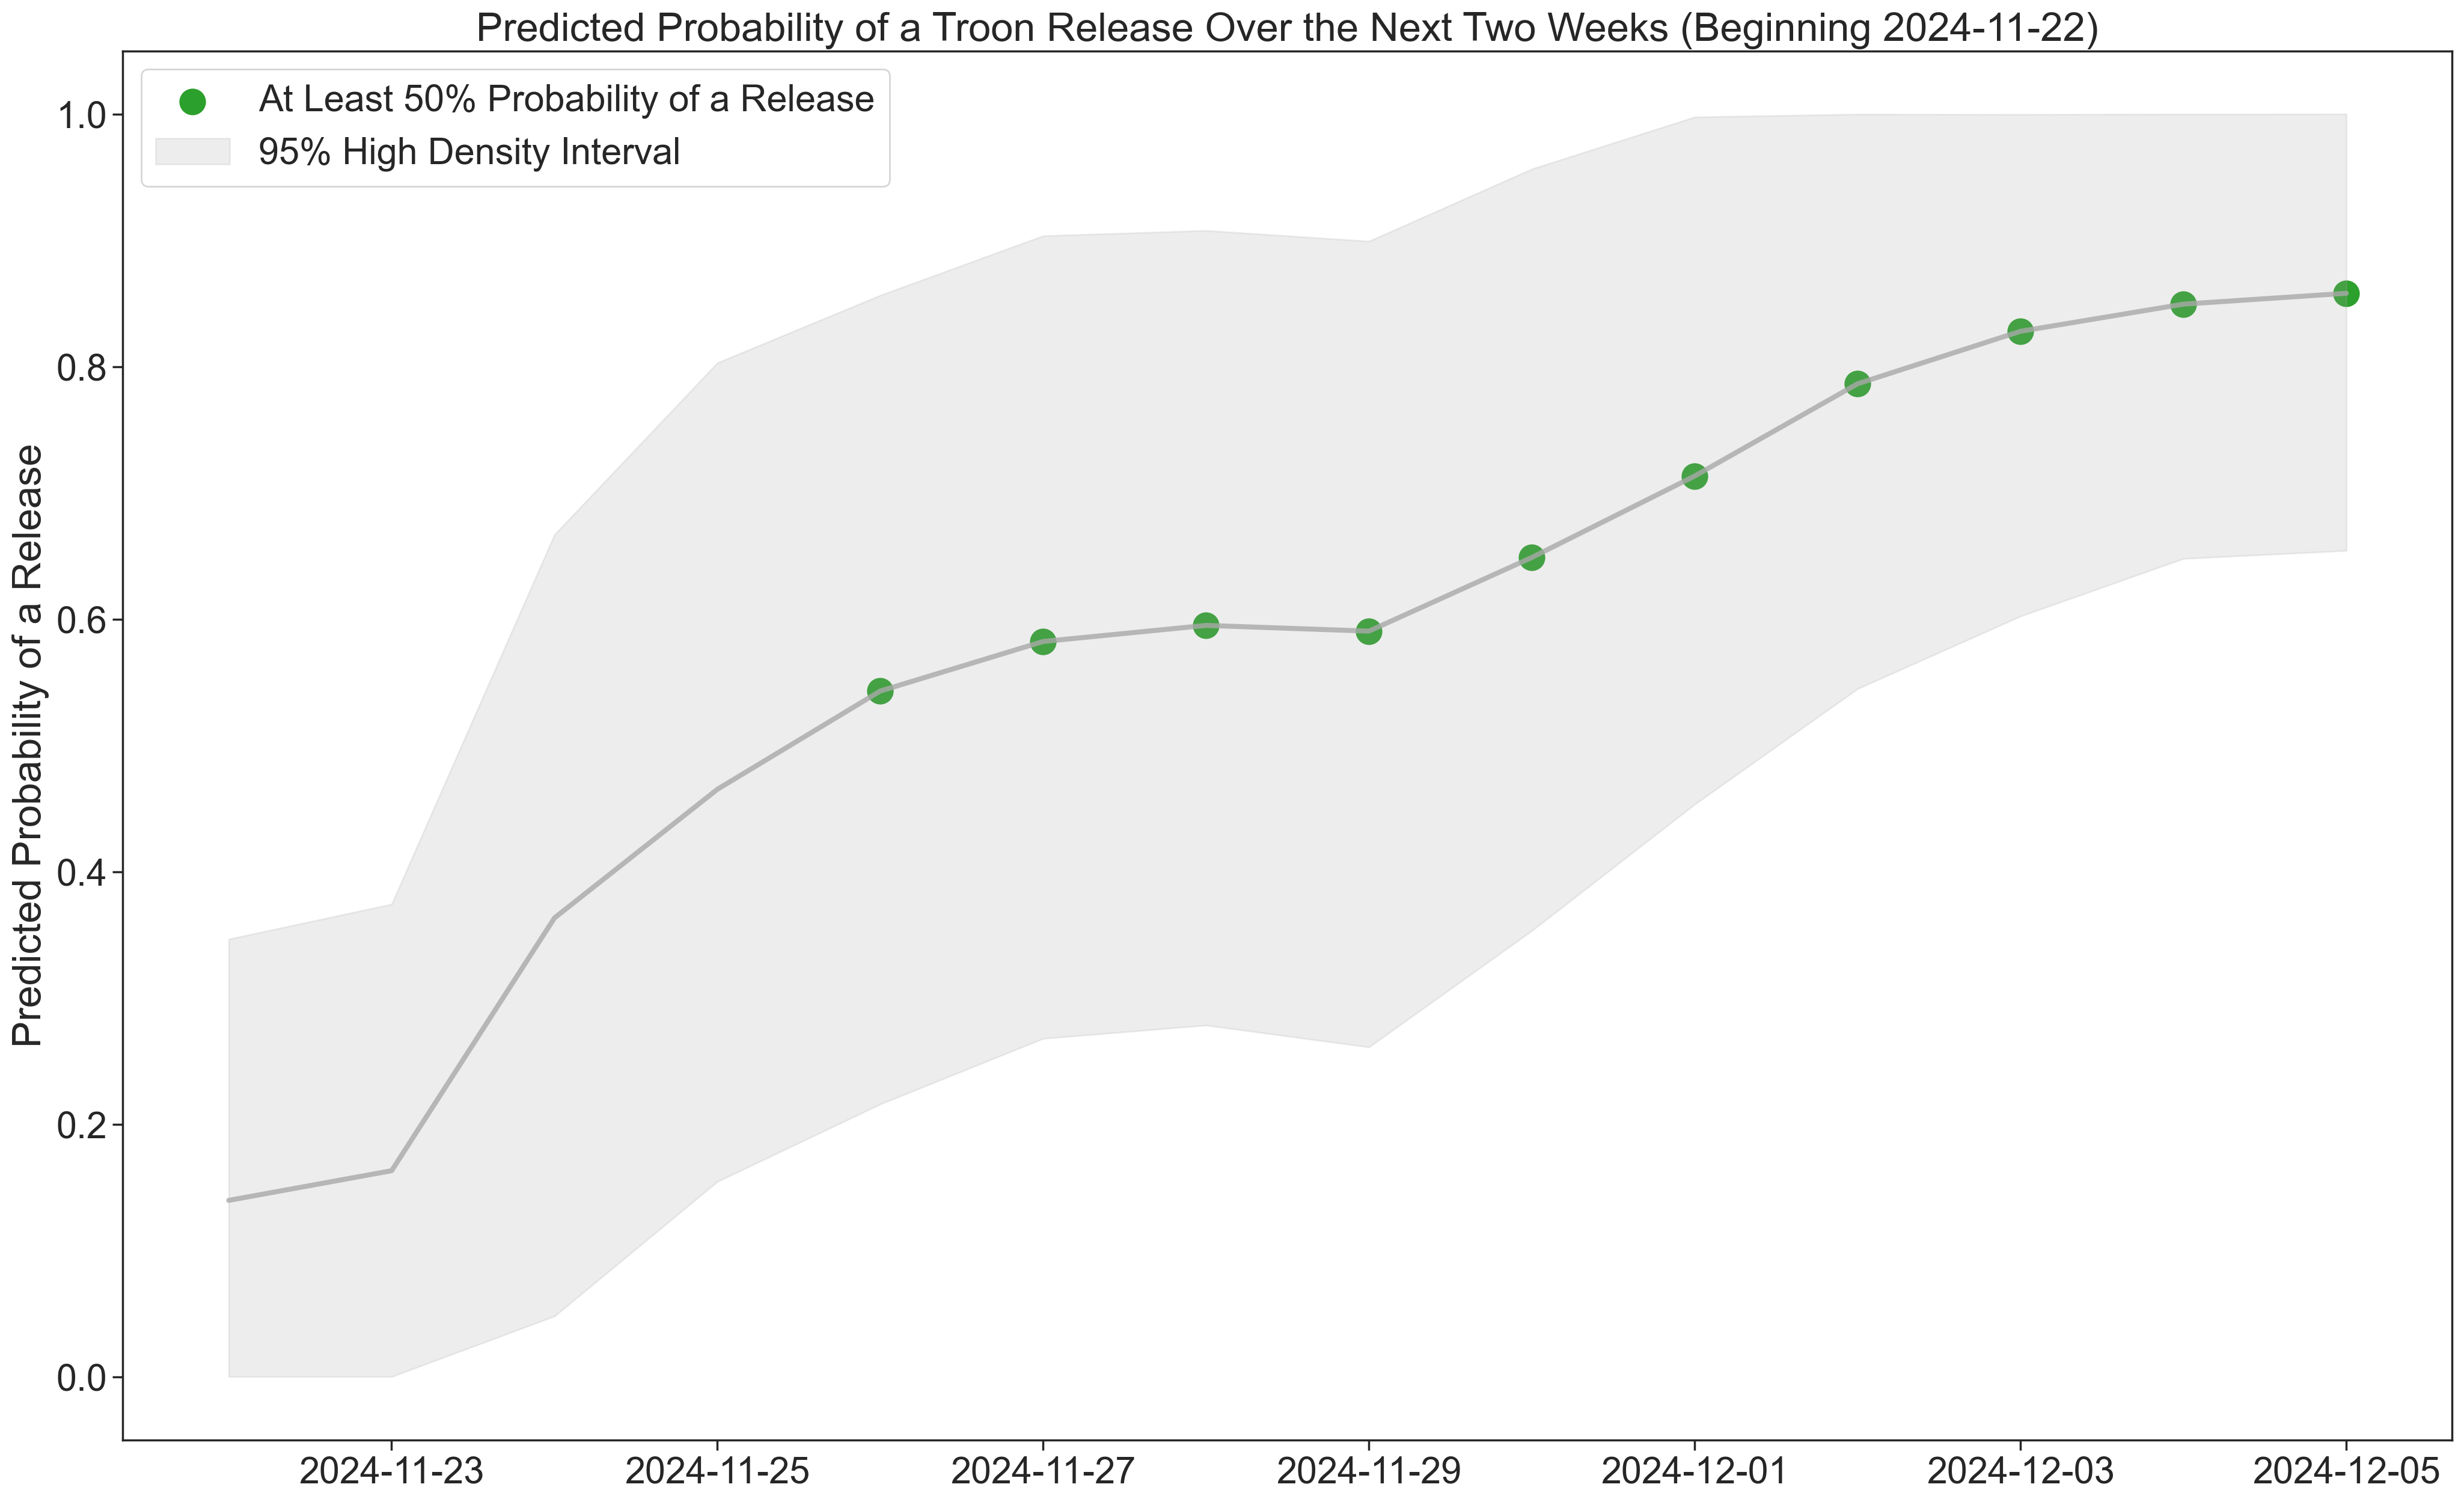

In [23]:
ax = sns.lineplot(data=next_two_weeks, x="index", y="predicted_prob", linewidth=3, color="darkgrey", alpha=0.8)
sns.scatterplot(data=next_two_weeks[next_two_weeks["predicted_prob"] >= 0.50], x="index", y="predicted_prob",
                s=300, ax=ax, color="tab:green", label="At Least 50% Probability of a Release")

ax.fill_between(x=next_two_weeks["index"],
                y1=next_two_weeks["predicted_min"],
                y2=next_two_weeks["predicted_max"],
                label="95% High Density Interval",
                alpha=0.2,
                color="darkgrey")

ax.set_xlabel(None)
ax.set_ylabel("Predicted Probability of a Release")
ax.set_title("Predicted Probability of a Troon Release Over the Next Two Weeks (Beginning {})".format(
    next_two_weeks["index"].iloc[0].date()))
ax.legend()
plt.show()